# Quantum Circuit, Boolean Functions and Universality

#### 1.  Implement a Boolean Function
Let $f : \{0, 1\}^n \rightarrow \{0, 1\}$ be a Boolean function that takes $n$ bits as input.

We can build a reversible circuit $C_f$ that takes $n + 1$ input qubits (the first $n$ are input to $f$) and returns $n + 1$ output qubits (the first $n$ are identical with the first $n$ qubits of the input), where $C_f : |x, y \rangle \rightarrow |x, y \oplus f(x)\rangle$. 


<img src="Image/img.png" width=350 />



Let's consider $f: \{0, 1\}^3 \rightarrow \{0, 1\}$ such that $f(x,y,z) = \neg(x \wedge y) \wedge z $, build the circuit corresponding to $C_f$


In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [2]:
#TODO


#### 2.  Reset Workspace Qubits

In the previous circuit we have used some extra workspace qubits.

In classical computing, we can discard redundant information to free up memory for other tasks without affecting results.  
In quantum computing, though, discarding correlated information can significantly alter computation results.
In fact, discard or overwrite a variable means measure it


In [3]:
# TODO verifies this on the previous exercise

To discard or reuse some qubits without side effects we need to reset their value, exploiting the reversible nature of quantum computation.
With boolean functions, this can be done automatically by the following circuit:

<img src="Image/img_1.png" width=500 />

The block labelled $C_f$ represents the function circuit. 
Then we copy the output $y = f(x)$ to another register. 
Finally, run the circuit for $C_f$ backwards (replacing each gate by its inverse gate) to erase the contents of the output and workspace registers.

Now implement the circuit in figure considering $C_f$ from the previous exercise

##### Hint
In qiskit `QuantumCircuit()` has the `.inverse()` methods to automatically compute the inverse of a circuit (i.e. to execute if backwards)

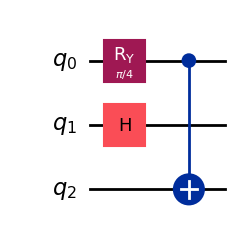

In [4]:
from math import pi

qc = QuantumCircuit(3)

qc.ry(pi/4,0)
qc.h(1)
qc.cx(0,2)
qc.draw('mpl')

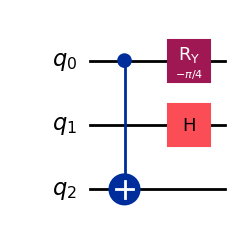

In [5]:
qc2 = qc.inverse()
qc2.draw('mpl')

In [6]:
# TODO implement the circuit that reset the workspace qubits



#### 3. Rotation Gates

The exponential of the Pauli matrices gives rise to three classes of unitary matrices, namely the rotation operators about the $x$, $y$, and $z$ axes, defined by:

$$
R_x(θ) ≡ e^{-iθσ_x/2} = cos(θ/2)I - isin(θ/2)σ_x = \begin{bmatrix} cos(θ/2) & -isin(θ/2)\\
                                                                   -isin(θ/2) & cos(θ/2) \end{bmatrix}                                                  
$$



$$
R_y(θ) ≡ e^{-iθσ_y/2} = cos(θ/2)I - isin(θ/2)σ_y = \begin{bmatrix} cos(θ/2) & -sin(θ/2)\\
                                                                    sin(θ/2) & cos(θ/2) \end{bmatrix}
$$

$$
R_z(θ) ≡ e^{-iθσ_z/2} = cos(θ/2)I - isin(θ/2)σ_z = \begin{bmatrix} e^{-iθ/2} & 0 \\
                                                                   0 & e^{iθ/2}  \end{bmatrix}
$$

Show that the Hadamard gate $H$ can be expressed as a product of $R_x$ and $R_z$ and $e^{i\phi}$ for some $\phi$.


In [7]:
# TODO implement the circuit and verify that the result

#### 4. Universality
##### 1
 
If for a single qubit unitary operation $U$ we have $U = V^2$ where V is another single qubit unitary operation, then the double controlled $U$ gate, called $CCU$ gate, can be implemented as: 

<img src="Image/img_2.png" width=600 />


Show that for $V = (1 — i)(I + iX)/2$, $CCU$ implements the Toffoli gate.
 

In [8]:
# TODO use Operator class




##### 2 
Check that:
1. $XYX = —Y$ and $XZX = —Z$;  
2. $XR_y(θ)X = R_y(-θ)$ and XR_z(θ)X = R_z(-θ). 



In [9]:
# TODO